In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive  Othercomputers


In [ ]:
cd /content/drive/MyDrive/NIS_collab

/content/drive/MyDrive/NIS_collab


In [ ]:
# !pip install MDAnalysis
# !pip install MDAnalysisTests MDAnalysisData
# !pip install mdtraj
# adk = datasets.fetch_adk_equilibrium()
# !pip install ncg
# !pip install wget
# !pip install utils

In [ ]:
import numpy as np
import torch
import numpy as np
import mdtraj as md  #  чтобы прочитать файл с датасетом
import matplotlib.pyplot as plt # для отрисовки графиков
from MDAnalysisData import datasets
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
class NeuralCoarseGraining:
    def __init__(self, input_dim, latent_dim, hidden_dim=100, learning_rate=0.001, num_epochs=100, batch_size=64):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.net = None
        
    def train(self, data):
        # определение архитектуры нейронной сети
        # добавляем пару слоёв
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.latent_dim)
        )

        # определение функции потерь и оптимизатора
        # по статье
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

        # обучение нейронной сети
        for epoch in range(self.num_epochs):
            # случайная выборка данных из обучающего набора
            idx = np.random.randint(data.shape[0], size=self.batch_size)
            input_data = torch.tensor(data[idx], dtype=torch.float32)

            # вычисление выхода нейронной сети и функции потерь
            output_data = self.net(input_data)
            loss = loss_fn(input_data, output_data)

            # обновление весов нейронной сети
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def project(self, data):
        # вычисление медленно меняющихся латентных переменных
        with torch.no_grad():
            input_data = torch.tensor(data, dtype=torch.float32)
            latent_data = self.net(input_data)
            latent_data = latent_data.numpy()

        return latent_data

    def compute_r2(self, data, latent_data):
        # оценка качества полученных результатов
        y_mean = np.mean(data, axis=0)
        ss_tot = np.sum(np.square(data - y_mean))
        ss_res = np.sum(np.square(data - self.project(latent_data)))
        r2 = 1 - ss_res / ss_tot

        return r2



In [ ]:
# Улучшенная модель с добавлением шума и энтропии

import numpy as np
import torch

class NeuralCoarseGraining_2:
    def __init__(self, input_dim, latent_dim, hidden_dim=100, learning_rate=0.001, num_epochs=100, batch_size=64, noise_level=0.1, entropy_coef=0.1):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.noise_level = noise_level
        self.entropy_coef = entropy_coef
        self.net = None
        
    def train(self, data):
        # определение архитектуры нейронной сети
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.latent_dim)
        )

        # определение функции потерь и оптимизатора
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

        # обучение нейронной сети
        for epoch in range(self.num_epochs):
            # случайная выборка данных из обучающего набора
            idx = np.random.randint(data.shape[0], size=self.batch_size)
            input_data = torch.tensor(data[idx], dtype=torch.float32)

            # добавление шума к входным данным
            input_data = input_data + self.noise_level * torch.randn_like(input_data)

            # вычисление выхода нейронной сети и функции потерь
            output_data = self.net(input_data)
            mse_loss = loss_fn(input_data, output_data)

            # вычисление энтропийной регуляризации
            probs = torch.softmax(output_data, dim=1)
            log_probs = torch.log_softmax(output_data, dim=1)
            entropy_loss = -torch.mean(torch.sum(probs * log_probs, dim=1))

            # общая функция потерь
            loss = mse_loss + self.entropy_coef * entropy_loss

            # обновление весов нейронной сети
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def project(self, data):
        # вычисление медленно меняющихся латентных переменных
        with torch.no_grad():
            input_data = torch.tensor(data, dtype=torch.float32)
            latent_data = self.net(input_data)
            latent_data = latent_data.numpy()

        return latent_data

    def compute_r2(self, data, latent_data):
        # оценка качества полученных результатов
        y_mean = np.mean(data, axis=0)
        ss_tot = np.sum(np.square(data - y_mean))
        ss_res = np.sum(np.square(data - self.project(latent_data)))
        r2 = 1 - ss_res / ss_tot

        return r2


In [109]:
# Загрузка тестовой траектории белка alanine dipeptide из библиотеки mdtraj
traj = md.load('ala2.h5')

# Извлечение координат атомов в каждом кадре траектории
data = traj.xyz.reshape(traj.n_frames, -1)

# Создание экземпляра класса и обучение на датасете
ncg = NeuralCoarseGraining(input_dim=data.shape[1], latent_dim=66, hidden_dim=100, learning_rate=0.001, num_epochs=500, batch_size=64)
ncg.train(data)

# Проекция на латентное пространство
latent_data = ncg.project(data)

# Оценка качества
r2 = ncg.compute_r2(data, latent_data)
print('R^2 score: ', r2)

R^2 score:  0.6901202201843262


In [106]:
ncg = NeuralCoarseGraining_2(input_dim=data.shape[1], latent_dim=66, hidden_dim=100, learning_rate=0.001, num_epochs=500, batch_size=64)
ncg.train(data)

# Проекция на латентное пространство
latent_data = ncg.project(data)

# Оценка качества
r2 = ncg.compute_r2(data, latent_data)
print('R^2 score: ', r2)

R^2 score:  0.7247138917446136


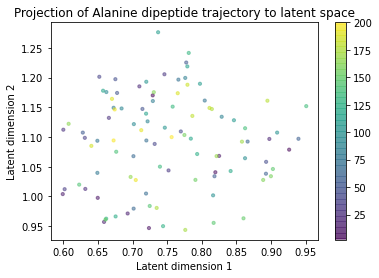

In [ ]:
# Load alanine dipeptide trajectory from mdtraj library
traj = md.load('ala2.h5')

# Select indices of atoms in the first and second residues
res1_atom_indices = traj.top.select('resid 1')
res2_atom_indices = traj.top.select('resid 2')

# Extract coordinates of selected atoms in each frame of the trajectory
res1 = traj.xyz[:, res1_atom_indices, :]
res2 = traj.xyz[:, res2_atom_indices, :]

# Reshape data into a 2D array
res1 = res1.reshape(res1.shape[0], -1)
res2 = res2.reshape(res2.shape[0], -1)

# Concatenate the two arrays to create the final dataset
data = np.concatenate([res1, res2], axis=1)

# Create an instance of NeuralCoarseGraining class and train on the dataset
ncg = NeuralCoarseGraining(input_dim=data.shape[1], latent_dim=48, hidden_dim=100, learning_rate=0.001, num_epochs=500, batch_size=64)
ncg.train(data)

# Project data onto the latent space
latent_data = ncg.project(data)

# Plot the projection
plt.scatter(latent_data[:, 0], latent_data[:, 1], s=10, alpha=0.5, c=traj.time)
plt.colorbar()
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Projection of Alanine dipeptide trajectory to latent space')
plt.show()


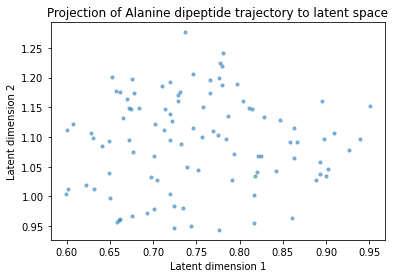

In [ ]:
# Построение графика точек в латентном пространстве
plt.scatter(latent_data[:, 0], latent_data[:, 1], s=10, alpha=0.5)

plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Projection of Alanine dipeptide trajectory to latent space')
plt.show()


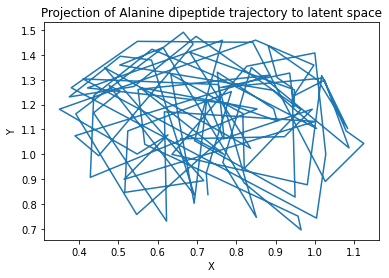

In [ ]:
# Загрузка тестовой траектории белка alanine dipeptide из библиотеки mdtraj
traj = md.load('ala2.h5')

# Извлечение координат атомов в каждом кадре траектории
data = traj.xyz.reshape(traj.n_frames, -1)

# Визуализация траектории
fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Projection of Alanine dipeptide trajectory to latent space')
plt.show()


/usr/local/lib/python3.8/dist-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


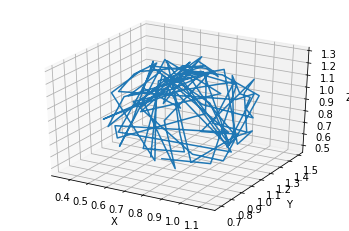

In [ ]:
# Загрузка тестовой траектории белка alanine dipeptide из библиотеки mdtraj
traj = md.load('ala2.h5')

# Извлечение координат атомов в каждом кадре траектории
data = traj.xyz.reshape(traj.n_frames, -1)

# Визуализация траектории
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:, 0], data[:, 1], data[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


/usr/local/lib/python3.8/dist-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


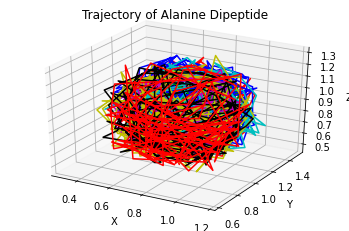

In [ ]:
import matplotlib.pyplot as plt
import mdtraj as md

# Загрузка тестовой траектории белка alanine dipeptide из библиотеки mdtraj
traj = md.load('ala2.h5')

# Извлечение координат атомов в каждом кадре траектории
data = traj.xyz

# Визуализация траектории
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Задание цветов для каждого атома
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

# Отображение движения каждого атома линией разных цветов
for i in range(data.shape[1]):
    ax.plot(data[:, i, 0], data[:, i, 1], data[:, i, 2], color=colors[i % len(colors)])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Trajectory of Alanine Dipeptide')
plt.show()


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Загрузка тестовой траектории белка alanine dipeptide из библиотеки mdtraj
traj = md.load('ala2.h5')

# Извлечение координат атомов в каждом кадре траектории
data = traj.xyz.reshape(traj.n_frames, -1)

# Создание экземпляра класса и обучение на датасете
ncg = NeuralCoarseGraining(input_dim=data.shape[1], latent_dim=66, hidden_dim=100, learning_rate=0.001, num_epochs=500, batch_size=64)
ncg.train(data)

# Проекция на латентное пространство
latent_data = ncg.project(data)

# Оценка качества
r2 = ncg.compute_r2(data, latent_data)
print('R^2 score: ', r2)

# Разбиение на train и test выборки
train_data, test_data = train_test_split(data, test_size=0.2)

# Обучение модели
model = PCA(n_components=10)
model.fit(train_data)

# Применение модели к тестовой выборке
test_data_transformed = model.transform(test_data)

# Преобразование данных в матрицу разностей
mat1 = test_data_transformed.repeat(test_data_transformed.shape[0], axis=0)
mat2 = np.tile(test_data_transformed, (test_data_transformed.shape[0], 1))
mat_diff = mat1 - mat2

# Вычисление расстояний
distances = np.sqrt(np.sum(mat_diff**2, axis=1))

# Оценка качества модели
# quality = evaluate_model(distances, test_data, test_data, 0.1)
# print('Model quality:', quality)


/usr/local/lib/python3.8/dist-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


R^2 score:  0.5923928916454315


In [56]:
from sklearn.neighbors import KDTree

In [81]:
# Загрузка тестовой траектории белка alanine dipeptide из библиотеки mdtraj
traj = md.load('ala2.h5')

# Извлечение координат атомов в каждом кадре траектории
data = traj.xyz.reshape(traj.n_frames, -1)

# Создание экземпляра класса и обучение на датасете
ncg = NeuralCoarseGraining_2(input_dim=data.shape[1], latent_dim=66, hidden_dim=100, learning_rate=0.001, num_epochs=500, batch_size=64)
ncg.train(data)

# Проекция на латентное пространство
latent_data = ncg.project(data)

# Разбиение на train и test выборки
train_data, test_data = train_test_split(data, test_size=0.2)

# Обучение модели
model = PCA(n_components=10)
model.fit(train_data)

# Применение модели к тестовой выборке
test_data_transformed = model.transform(test_data)

# Вычисление расстояний
tree = KDTree(test_data_transformed)
distances, _ = tree.query(test_data_transformed, k=2)

# Оценка качества модели как суммарное расстояние между точками изначльных точек и модели
quality = np.mean(distances[:, 1])
print('Model quality:', quality)
# 0.7723685143288957

/usr/local/lib/python3.8/dist-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


Model quality: 0.7643738816358351


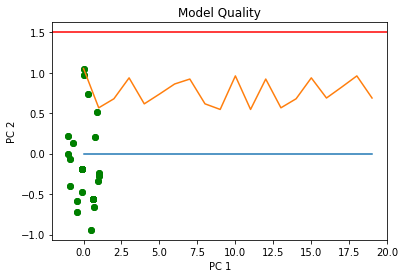

In [82]:
import matplotlib.pyplot as plt

# Plot the distances and the cutoff value
plt.plot(distances)
plt.axhline(y=1.5, color='r', linestyle='-')

# Find the pairs of points that have a distance below the cutoff value
indices = np.where(distances < 1.5)
x = test_data_transformed[indices, 0]
y = test_data_transformed[indices, 1]

# Highlight the pairs of points
plt.scatter(x, y, color='g')

# Set the axis labels and the title
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Model Quality')

# Show the plot
plt.show()


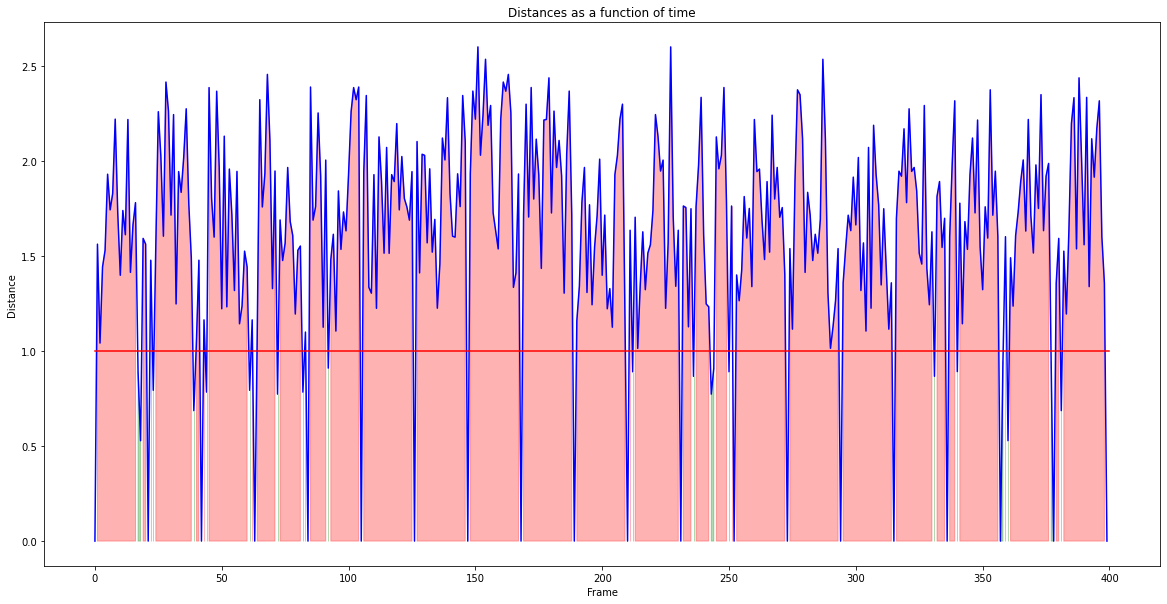

In [88]:
import matplotlib.pyplot as plt

# Define the cutoff value
cutoff_value = 1

fig, ax = plt.subplots(figsize=(20, 10))
# Plot the distances as a function of time with different colors for distances above or below the cutoff value
plt.plot(distances, color='blue')
plt.plot([0, len(distances)], [cutoff_value, cutoff_value], color='red')
plt.fill_between(range(len(distances)), distances, where=distances<=cutoff_value, color='green', alpha=0.3)
plt.fill_between(range(len(distances)), distances, where=distances>cutoff_value, color='red', alpha=0.3)

# Add axis labels and a title
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.title('Distances as a function of time')

# Display the plot
plt.show()
